# Perform classification using a single layer perceptron

In [1]:
import itertools
import math
import numpy as np
import operator
import random

from matplotlib import pyplot as plt
%matplotlib inline

import sympy as sp
from sympy.functions.elementary.exponential import exp
from sympy.utilities.lambdify import lambdify

# Generate sample data

https://en.wikipedia.org/wiki/Rotation_matrix

https://en.wikipedia.org/wiki/Multivariate_normal_distribution

In [2]:
# Rotation matrix
def rot(theta):
    theta = np.radians(theta)
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [3]:
# Sample points from a rotated 2-dimensional gaussian distribution
def sample_2d_normal(center, sd_x, sd_y, theta, N):
    
    # Covariance matrix
    cov = np.diag([sd_x ** 2, sd_y ** 2])
    
    # Rotation matrix
    R = rot(-theta)

    # Rotate covariance matrix
    cov = np.dot(R, cov).T

    # Sample points from the rotated distribution
    return np.random.multivariate_normal(center, cov, N).T

In [4]:
## First cluster of points

# Number of data points
N1 = 1000

# Data
x1 = sample_2d_normal([-3, 3], sd_x=1, sd_y=2, theta=45, N=N1)

# Labels
y1 = np.array([0] * N1)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [5]:
## Second cluster of points

# Number of data points
N2 = 1000

# Data
x2 = sample_2d_normal([1, -1], sd_x=2, sd_y=1, theta=45, N=N2)

# Labels
y2 = np.array([1] * N2)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.


In [6]:
## Together

# Number of data points
N = N1 + N2

# Data
x = np.concatenate([x1, x2], axis=1)

# Labels
y = np.concatenate([y1, y2])

In [7]:
# Shuffle dataset
index = list(np.random.permutation(N))
x = x[:, index]
y = y[index]

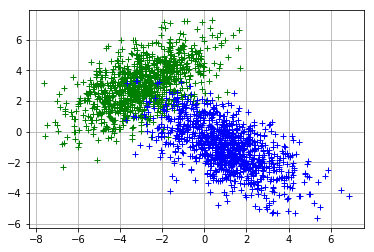

In [8]:
# Plot data
def plot_data(x, y):
    plt.plot(x[0, y == 0], x[1, y == 0], 'g+')
    plt.plot(x[0, y == 1], x[1, y == 1], 'b+')
    plt.grid()

plot_data(x, y)

**Goal:** separate the two clusters of points as best as possible with a line.

## Model

In [9]:
# Add ones to data, so that a bias can be learned by the model
z = np.vstack([x, np.array([1] * N)])

In [10]:
# Linear combination of weights and data
def f(w, z):
    return np.dot(w.T, z)

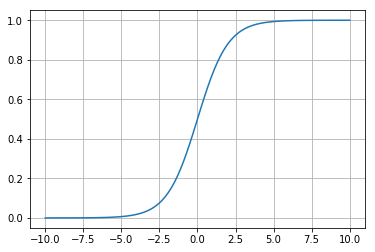

In [11]:
# Activation function

# As a convention, let's prefix the sympy variables and functions with an underscore.

# Symbolic activation function (logistic)
def _activation(_h):
    return 1 / (1 + exp(-_h))

# A symbolic variable. In practice, variable `h` designates `f(w, z)`.
_h = sp.var('h')

# Regular python activation function
activation = lambdify(h, _activation(h))

# Plot activation function
plot_x = np.linspace(-10, 10, 100)
plot_y = np.vectorize(activation)(plot_x)
plt.plot(plot_x, plot_y)
plt.grid()

The model is equivalent to a single layer neural network.

For a vector of weights $w \in \mathbb{R}^3$ and a point $z \in \mathbb{R}^3$, the model is going to be $sgn(activation(f(w, z))$, where $sgn$ is the sign function.

If $sgn(activation(f(w, z)) < 0$, the point is assigned to the first class.

Conversely, if $sgn(activation(f(w, z)) > 0$, the point is assigned to the second class.

## Error definition

In [12]:
# Symbolic variable for labels
_y = sp.var('_y')

# Error function (squared error): error commited by the model at one data point
_error = (_activation(_h) - _y) ** 2

In [13]:
# Regular python error function
error = lambdify((_h, _y), _error)

In [14]:
# Loss function: error commited by the model for all data points
def loss(w, z, y):
    N = z.shape[1]
    return sum(error(f(w, z[:, i]), y[i]) for i in range(N))

## Gradient of the error

In [15]:
# Symbolic derivative of error which respect to `h`
_d_error = _error.diff(_h)

# Regular python function for the derivative of error
d_error = lambdify((_h, _y), _d_error)

Using [chain rule](https://en.wikipedia.org/wiki/Chain_rule):

$$
error\_gradient(w, z, y) = \nabla_w error(f(w, z), y) = d\_error(f(w, z), y) \cdot \underbrace{\nabla_w f(w, z)}_{z} \ \ \ \ \ \ \ (1)
$$

To go further let's derive the [delta rule](https://en.wikipedia.org/wiki/Delta_rule).

Let's substitute $h$ for $f(w, z)$.

If we assume $error$ to be defined as $error(h, y) = (activation(h) - y)^2$, then, using the chain rule again:

$$
d\_error(h, y) = \frac{\partial error}{\partial h} = 2 \cdot (activation(h) - y) \cdot d\_activation(h)
$$

Furthermore, if we assume $activation$ to be the logistic function defined as $activation(h) = \frac{1}{1+e^{-h}}$, which has a derivative nicely expressed as:

$$
d\_activation(h) = \frac{\partial activation}{\partial h} = activation(h) \cdot (1 - activation(h))
$$

Then:

$$
d\_error(h, y) = 2 \cdot (activation(h) - y) \cdot activation(h) \cdot (1 - activation(h))
$$

Which finally gives, substituting $d\_error(h, y)$ in $(1)$:

$$
error\_gradient(w, z, y) = 2 \cdot (activation(f(w, z)) - y) \cdot activation(f(w, z)) \cdot (1 - activation(f(w, z)) \cdot z \ \ \ \ \ \ \ (2)
$$

However, let's stick to $(1)$, which allows for any derivable $error$ and $activation$ functions.

In [16]:
# By equation (1):
def error_gradient(w, z, y):
    return d_error(f(w, z), y) * z

# Alternatively (and faster), by equation (2):
#def error_gradient(w, z, y):
#    a = activation(f(w, z))
#    return 2 * (a - y) * a * (1 - a) * z

## Stochastic gradient descent algorithm

https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [17]:
# Update rule
def update(w, z, y, lr):
    # `lr` stands for "learning rate"
    return w - lr * error_gradient(w, z, y)

In [18]:
def sgd(z, y, initial_weights, lr):

    w = initial_weights
    N = z.shape[1]
    
    while True:
        
        # Stochastic part of the algorithm: choose a data point at random for this iteration.
        i = random.randint(0, N - 1)
        
        w = update(w, z[:, i], y[i], lr)
        current_loss = loss(w, z, y)
        yield w, current_loss

## Run algorithm

In [19]:
# Set learning rate
lr = 0.05

# Numbers of iterations
steps_nb = 1000

# Initialize weights
w = np.array([1, 1, 0])

# Initialize algorithm

current_loss = 1
step = 0

loss_history = []
weights_history = []

gen = sgd(z, y, w, lr)

# Run algorithm

for step in range(1, steps_nb + 1):

    w, current_loss = next(gen)

    weights_history.append(w)
    loss_history.append(current_loss)

    # Pretty-printing ironically requires code that is not so pretty
    if step % 10 ** (len(str(step)) - 1) == 0 or step == steps_nb:
        print('step %s, loss = %.10f' % (str(step).zfill(len(str(steps_nb))), current_loss))

step 0001, loss = 697.5718062161
step 0002, loss = 704.6900142874
step 0003, loss = 692.1266263438
step 0004, loss = 659.0153062459
step 0005, loss = 642.3806871094
step 0006, loss = 638.6319017215
step 0007, loss = 619.6239926082
step 0008, loss = 602.5098611601
step 0009, loss = 607.1708293753
step 0010, loss = 593.6146136948
step 0020, loss = 513.1680864462
step 0030, loss = 472.5162537971
step 0040, loss = 397.4277248683
step 0050, loss = 316.1336774589
step 0060, loss = 301.5001234511
step 0070, loss = 240.6909008556
step 0080, loss = 235.2592608963
step 0090, loss = 231.8908816714
step 0100, loss = 220.2694288176
step 0200, loss = 167.8229383683
step 0300, loss = 145.7700619670
step 0400, loss = 128.2229664384
step 0500, loss = 113.4705637578
step 0600, loss = 103.1855463026
step 0700, loss = 90.8131514441
step 0800, loss = 84.2415806229
step 0900, loss = 79.5415580264
step 1000, loss = 78.2428348739


## Plot loss history

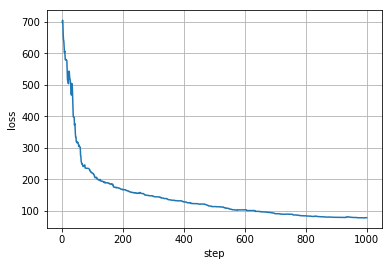

In [20]:
x_plot = list(range(1, len(loss_history) + 1))
y_plot = list(loss_history)

plt.plot(x_plot, y_plot)
plt.xlabel ('step')
plt.ylabel ('loss')
plt.grid()

plt.show()

## Visualize algorithm

The best way to visualize what the model is doing is to plot the decision surface, which is the set of points for which $sgn(activation(f(w, z)) = 0$.

Let's find the equation of the decision surface.

For all points $x = (x_1, x_2)$, which translates as $z = (x_1, x_2, 1)$:

$$
sgn(activation(f(w, z)) = 0 \\
\Leftrightarrow \\
w_1 \cdot \underbrace{z_1}_{x_1} + w_2 \cdot \underbrace{z_2}_{x_2} + w_3 \cdot \underbrace{z_3}_{1} = 0 \\
\underset{w_2 \neq 0,\ please}{\Leftrightarrow} \\
x_2 = - \frac{w_1}{w_2} \cdot x_1 - \frac{w_3}{w_2}
$$

... which is the equation of a line.

About decision surfaces: http://www.cs.stir.ac.uk/courses/ITNP4B/lectures/kms/2-Perceptrons.pdf, slide 7

In [21]:
def decision_surface(w, x_1):
    return -w[0] / w[1] * x_1 - w[2] / w[1]

In [22]:
# Plot data along with the decision surface of the model
def plot(w, x, y):
    
    # Plot data
    plt.plot(x[0, y == 0], x[1, y == 0], 'g+')
    plt.plot(x[0, y == 1], x[1, y == 1], 'b+')
        
    # Get data bounds
    x_min, x_max = x[0, :].min(), x[0, :].max()
    x_range = x_max - x_min
    y_min, y_max = x[1, :].min(), x[1, :].max()
    y_range = y_max - y_min

    # Enlarge data bounds for prettier plotting
    unzoom_matio = 0.1
    x_min -= unzoom_matio * x_range
    x_max += unzoom_matio * x_range
    y_min -= unzoom_matio * y_range
    y_max += unzoom_matio * y_range

    # Set graph limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Plot the decision surface of the model
    x1_min, x1_max = -100, 100
    x2_min = decision_surface(w, x1_min)
    x2_max = decision_surface(w, x1_max)
    plt.plot([x1_min, x1_max], [x2_min, x2_max], 'r')

    plt.grid()

In [23]:
# Find a set of losses at which to display the progression of the algorithm

# Get loss bounds
loss_min, loss_max = min(loss_history), max(loss_history)
loss_range = loss_max - loss_min

# Split losses
selected_losses = [loss_max - r * loss_range for r in (0, 0.8, 0.9, 1)]
selected_losses = sorted(selected_losses, reverse=True)

selected_losses

[704.6900142873774, 203.00819617909355, 140.29796891555804, 77.5877416520226]

In [24]:
# Find a set of strictly increasing steps for which the loss is around `selected_losses`

selected_steps = []

i = 0
for step, current_loss in enumerate(loss_history):

    if current_loss <= selected_losses[i]:
        selected_steps.append(step + 1)
        i += 1

    if i >= len(selected_losses):
        break

# Float comparison is tricky. Make the step corresponding
# to the lowest loss has been selected. 
if len(selected_steps) < len(selected_losses):
    selected_steps.append(steps_nb - 1)

selected_steps

[1, 115, 334, 999]

step 1


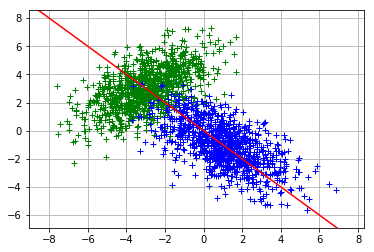

step 115


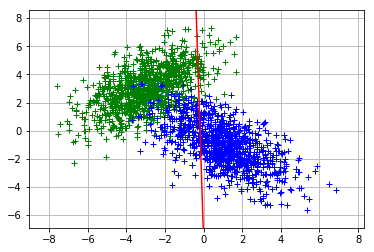

step 334


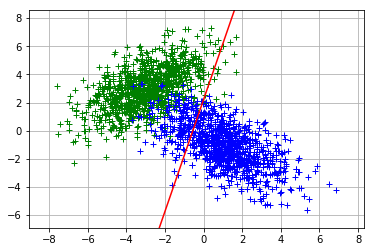

step 999


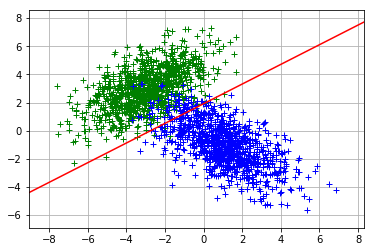

In [25]:
# Visualize
for step in selected_steps:
    print('step %i' % (step))
    plot(weights_history[step - 1], x, y)
    plt.show()

## Re-plot loss history

Highlight `selected_steps` this time

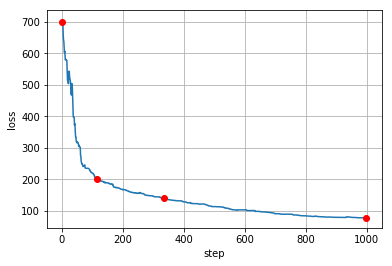

In [26]:
x_plot = list(range(1, len(loss_history) + 1))
y_plot = list(loss_history)

selected_losses = [loss_history[step - 1] for step in selected_steps]

plt.plot(x_plot, y_plot)
plt.plot(selected_steps, selected_losses, 'ro')

plt.xlabel ('step')
plt.ylabel ('loss')
plt.grid()

plt.show()

## Plot weights history

Highlight `selected_steps` as well

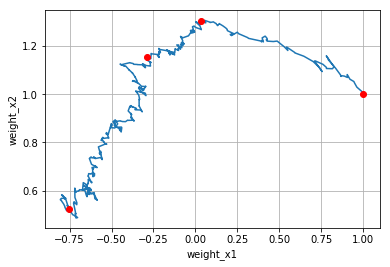

In [27]:
weights_x2 = list(map(operator.itemgetter(1), weights_history))
weights_x1 = list(map(operator.itemgetter(0), weights_history))

selected_weights_x2 = [weights_history[step - 1][1] for step in selected_steps]
selected_weights_x1 = [weights_history[step - 1][0] for step in selected_steps]

plt.plot(weights_x2, weights_x1)
plt.plot(selected_weights_x2, selected_weights_x1, 'ro')

plt.xlabel ('weight_x1')
plt.ylabel ('weight_x2')
plt.grid()

plt.show()